### We plan to compute the L2 norm as convergenc analysis:




In computational mechanics, the L2 norm (or L2 error) is a crucial tool for measuring the error between the numerical solution and the analytical solution. When performing convergence analysis, handling the L2 norm generally involves the following steps:

1. **Define the L2 Norm:**
   For a function \( u \) defined on a domain $ \Omega $, the L2 norm is defined as:
   $$
   \|u\|_{L2} = \left( \int_{\Omega} |u(x)|^2 \, dx \right)^{1/2}
   $$

2. **Compute the Error:**
   Let $u$ be the exact solution and $u_h$ be the numerical solution. The error is defined as $ e = u - u_h $. We are interested in the L2 norm of the error:
   $$
   \|e\|_{L2} = \left( \int_{\Omega} |u(x) - u_h(x)|^2 \, dx \right)^{1/2}
   $$

3. **Discretize the Error Calculation:**
   In practice, the domain $ \Omega $ is typically discretized into a finite number of elements, so the integral can be approximated using numerical integration methods (e.g., Gaussian quadrature). The discrete L2 norm of the error is calculated as:
   $$
   \|e\|_{L2} \approx \left( \sum_{i=1}^{N} w_i |u(x_i) - u_h(x_i)|^2 \right)^{1/2}
   $$
   where $ w_i $ are the numerical integration weights and $ x_i $ are the integration points.



4. **Perform Convergence Analysis:**
   To analyze the convergence of the numerical solution, we typically refine the mesh (i.e., reduce the element size \( h \)), calculate the L2 norm of the error for different mesh sizes, and observe how the L2 error changes with the mesh size. Ideally, the error should satisfy a convergence rate, such as:
   $$
   \|e\|_{L2} \leq Ch^p
   $$
   where \( C \) is a constant and \( p \) is the order of convergence.

5. **Conduct Numerical Experiments and Validation:**
   Through numerical experiments, compute the L2 error for different mesh sizes and plot the error versus mesh size on a log-log plot. In this plot, the slope of the line represents the convergence rate \( p \).

6. **Error Estimation and Theoretical Analysis:**
   Combine specific finite element theory to provide theoretical error estimates and compare these with the numerical experiment results. For example, for a second-order elliptic equation, the finite element method theoretically has an $ O(h^2) $ convergence rate in the L2 norm.


```python
# Pseudocode example for computing L2 norm error
import numpy as np

def compute_l2_error(u_exact, u_numeric, weights, points):
    error = 0.0
    for i in range(len(points)):
        error += weights[i] * (u_exact(points[i]) - u_numeric(points[i]))**2
    return np.sqrt(error)

# Assuming we have two solution functions u_exact and u_numeric, as well as integration points and weights
points = [...]
weights = [...]
u_exact = lambda x: ...  # Exact solution
u_numeric = lambda x: ...  # Numerical solution

l2_error = compute_l2_error(u_exact, u_numeric, weights, points)
print(f"L2 error: {l2_error}")
```

### We should apply Johnson(1985) solution as analytical solution, our computation is for demi-sphere and flat surface.

We would like to have a generalized Maxwell model with one pure elastic branch and one Maxwell branch. For parameter setting, we would like to have $2*G_\infty$ at t=0.

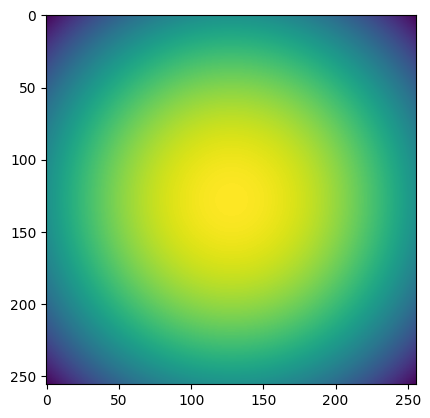

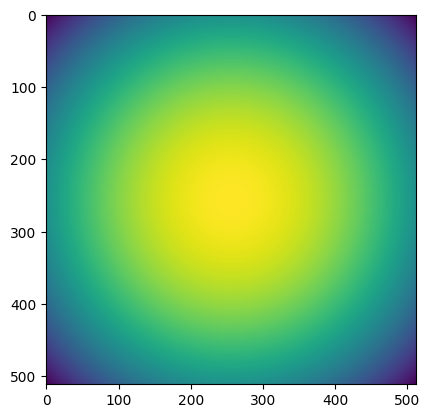

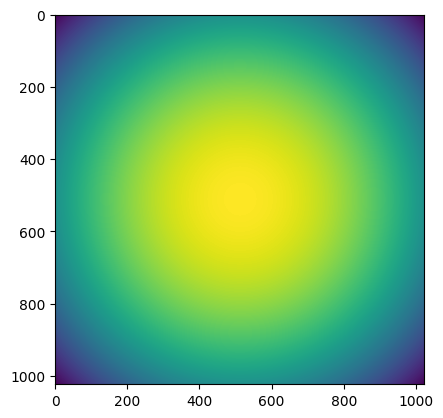

In [1]:
import tamaas as tm
import matplotlib.pyplot as plt

import tamaas.utils
import numpy as np

# parallel computation
tm.initialize(8)

# discretization
n_list = [256, 512, 1024]


##load(constant)
W = 1e0  # Total load

L = 1.  # Domain size
Radius = 0.01

physical_size = [L, L]


models = []
surfaces = []

for n in n_list:
    discritization = [n, n]
    model = tm.Model(tm.model_type.basic_2d, physical_size, discritization)
    model.E = 3
    model.nu = 0.5
    E_star = model.E / (1 - model.nu**2)
    shear_modulus = [model.mu]
    characteristic_time = [1] 
    models.append(model)
    
    surface = tm.utils.hertz_surface(physical_size, discritization, Radius)
    surfaces.append(surface)
    
    plt.imshow(surface)
    plt.show()


In [40]:
G_inf = model.mu
G = shear_modulus

print('G_inf:', G_inf, ' G: ' + str(G))

tau = characteristic_time#[1]#[0.1, 1] #relaxation time
eta = [g * t for g, t in zip(G, tau)]

print('tau:', tau, ' eta: ' + str(eta))

nu = 0.5


Ac_Johnson_ref = []
g_1 = 2*(G[0] + G_inf)
g_2 = -g_1*(2*G_inf/(2*G_inf-g_1))

e_1 = 2 * (G[0] + G_inf) * (1+model.nu)
K = 2 * G_inf * (1+model.nu)
tau_c = [t*e_1/K for t in tau]

tau_c

G_inf: 1.0  G: [1.0]
tau: [1]  eta: [1.0]


[2.0]

#### Normalization:

$$
A_c / L^2
$$

$$
t / \tau_1
$$

In [41]:
Ac_tamaas = []

#solve for target pressure
p_target = W / (L**2) #avarge pressure
#normalized pressure
h_rms_prime = tm.Statistics2D.computeSpectralRMSSlope(surface)

#solver.solve(p_target)
time_steps_list = np.geomspace(4,800,10 , dtype=int)#[2, 20, 30, 50, 80, 100, 150, 250, 400, 800, 1200, 1600]
#L2_norms = []
error_list = []

##time
t0 = 0
t1 = 10 
## normalized time
t0 = 0/np.min(characteristic_time)
t1 = 10/np.min(characteristic_time)



In [42]:
##Hertz solution at t0 
G_maxwell_t0 = 0
for k in range(len(G)):
    G_maxwell_t0 += G[k]
G_effective_t0 = G_inf + G_maxwell_t0
E_effective_t0 = 2*G_effective_t0*(1+nu)/(1-nu**2)

p0_t0 = (6*W*(E_effective_t0)**2/(np.pi**3*Radius**2))**(1/3)
a_t0 = (3*W*Radius/(4*(E_effective_t0)))**(1/3)
##Hertz solution at t_inf
E_effective_inf = 2*G_inf*(1+nu)/(1-nu**2)

p0_t_inf = (6*W*(E_effective_inf)**2/(np.pi**3*Radius**2))**(1/3)
a_t_inf = (3*W*Radius/(4*(E_effective_inf)))**(1/3)


Ac_hertz_t0 = np.pi*a_t0**2
Ac_hertz_t_inf = np.pi*a_t_inf**2

 Iter          Cost_f           Error
    0    3.812791e-02    5.307689e-01
   70    1.002805e+00    7.498241e-13
 Iter          Cost_f           Error
    0    5.348936e-01    1.085179e-02
   55    1.258189e+00    8.361642e-13
 Iter          Cost_f           Error
    0    6.009706e-01    4.015413e-03
   60    1.358870e+00    4.361231e-13
 Iter          Cost_f           Error
    0    6.292354e-01    1.403363e-03
   55    1.399936e+00    9.942003e-13


[np.float64(0.0408477783203125), np.float64(0.0448760986328125), np.float64(0.0467071533203125)]
[np.float64(0.04309094174405238), np.float64(0.04645334168481716), np.float64(0.04739428799215573)]
3
3


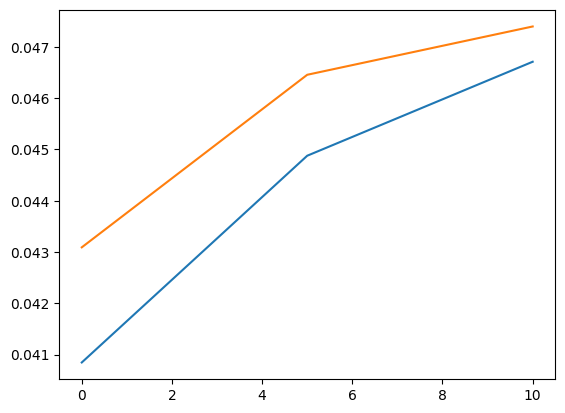

 Iter          Cost_f           Error
    0    3.156486e-01    1.323526e-02
   59    1.039427e+00    8.153884e-13
 Iter          Cost_f           Error
    0    5.708142e-01    1.090250e-02
   59    1.326244e+00    6.872169e-13
 Iter          Cost_f           Error
    0    6.748464e-01    5.570520e-03
   62    1.476854e+00    5.207588e-13
 Iter          Cost_f           Error
    0    7.319220e-01    2.778581e-03
   57    1.557912e+00    9.762672e-13
 Iter          Cost_f           Error
    0    7.632938e-01    1.388930e-03
   54    1.602364e+00    9.754431e-13
 Iter          Cost_f           Error
    0    7.806588e-01    6.533613e-04
   50    1.627034e+00    9.183142e-13
 Iter          Cost_f           Error
    0    7.903353e-01    3.155744e-04
   48    1.640863e+00    7.670059e-13


[np.float64(0.0382843017578125), np.float64(0.0424957275390625), np.float64(0.0448760986328125), np.float64(0.0461578369140625), np.float64(0.0469512939453125), np.float64(0.0476837158203125)]
[np.float64(0.03961593326084388), np.float64(0.04387292296553237), np.float64(0.04588265332696761), np.float64(0.04685055984194041), np.float64(0.04732075687161024), np.float64(0.04755008753641947)]
6
6


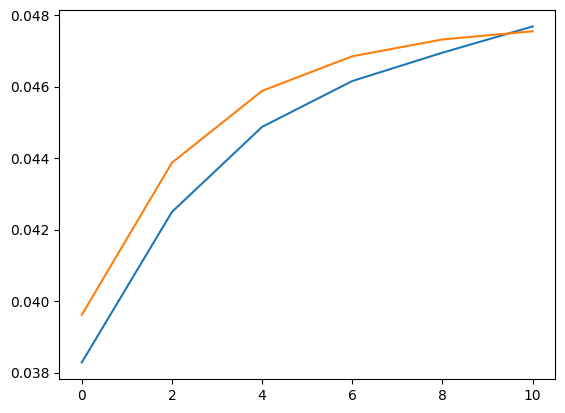

 Iter          Cost_f           Error
    0    3.130240e-01    1.527652e-02
   59    1.075976e+00    9.796871e-13
 Iter          Cost_f           Error
    0    5.743259e-01    9.653067e-03
   58    1.354919e+00    8.948622e-13
 Iter          Cost_f           Error
    0    7.034546e-01    6.218080e-03
   55    1.535474e+00    8.388617e-13
 Iter          Cost_f           Error
    0    7.888799e-01    3.931300e-03
   57    1.654255e+00    7.787048e-13
 Iter          Cost_f           Error
    0    8.457738e-01    2.454866e-03
   57    1.733393e+00    6.615643e-13
 Iter          Cost_f           Error
    0    8.838835e-01    1.526741e-03
   56    1.786582e+00    6.798830e-13
 Iter          Cost_f           Error
    0    9.095326e-01    9.803419e-04
   54    1.822686e+00    6.198054e-13
 Iter          Cost_f           Error
    0    9.269431e-01    5.866020e-04
   52    1.847307e+00    8.727484e-13
 Iter          Cost_f           Error
    0    9.387832e-01    3.766052e-04
   40    1.8

[np.float64(0.0360260009765625), np.float64(0.0395660400390625), np.float64(0.0420684814453125), np.float64(0.0440216064453125), np.float64(0.0452423095703125), np.float64(0.0459136962890625), np.float64(0.0467071533203125), np.float64(0.0471954345703125), np.float64(0.0476837158203125), np.float64(0.0476837158203125), np.float64(0.0476837158203125)]
[np.float64(0.036590186021927006), np.float64(0.04057089682651544), np.float64(0.04309094174405238), np.float64(0.04471256428338764), np.float64(0.045765674621851916), np.float64(0.04645334168481716), np.float64(0.04690390707125092), np.float64(0.04719975756773412), np.float64(0.04739428799215573), np.float64(0.04752231225071476), np.float64(0.047606616797847154)]
11
11


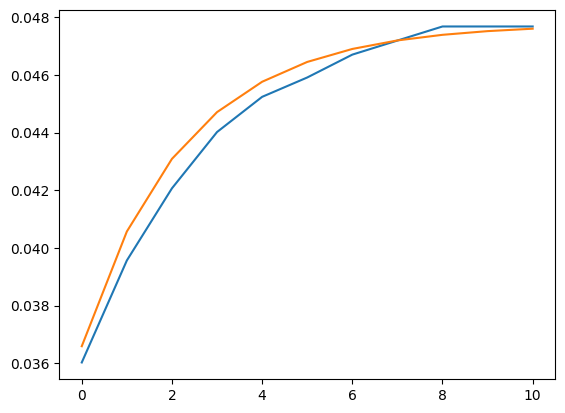

 Iter          Cost_f           Error
    0    3.104680e-01    1.685790e-02
   57    1.114919e+00    7.587413e-13
 Iter          Cost_f           Error
    0    5.415051e-01    7.208213e-03
   52    1.340796e+00    8.911759e-13
 Iter          Cost_f           Error
    0    6.699467e-01    5.559214e-03
   56    1.515344e+00    6.890390e-13
 Iter          Cost_f           Error
    0    7.696868e-01    4.290470e-03
   61    1.651125e+00    6.734036e-13
 Iter          Cost_f           Error
    0    8.476762e-01    3.276224e-03
   55    1.757556e+00    8.828823e-13
 Iter          Cost_f           Error
    0    9.089220e-01    2.485237e-03
   57    1.841323e+00    7.259291e-13
 Iter          Cost_f           Error
    0    9.571283e-01    1.922965e-03
   54    1.907704e+00    8.064284e-13
 Iter          Cost_f           Error
    0    9.953200e-01    1.443649e-03
   54    1.960446e+00    9.745506e-13
 Iter          Cost_f           Error
    0    1.025593e+00    1.081926e-03
   51    2.0

[np.float64(0.0338287353515625), np.float64(0.0365142822265625), np.float64(0.0388336181640625), np.float64(0.0403594970703125), np.float64(0.0419464111328125), np.float64(0.0428009033203125), np.float64(0.0440216064453125), np.float64(0.0447540283203125), np.float64(0.0452423095703125), np.float64(0.0457305908203125), np.float64(0.0461578369140625), np.float64(0.0467071533203125), np.float64(0.0468292236328125), np.float64(0.0470733642578125), np.float64(0.0471954345703125), np.float64(0.0476837158203125), np.float64(0.0476837158203125), np.float64(0.0476837158203125), np.float64(0.0476837158203125), np.float64(0.0476837158203125), np.float64(0.0478057861328125), np.float64(0.0478057861328125)]
[np.float64(0.033895021268878084), np.float64(0.03680519797594616), np.float64(0.03906549885022917), np.float64(0.040837656361117775), np.float64(0.04223607373379916), np.float64(0.04334465298492078), np.float64(0.04422643515322445), np.float64(0.04492959452926114), np.float64(0.045491395173736

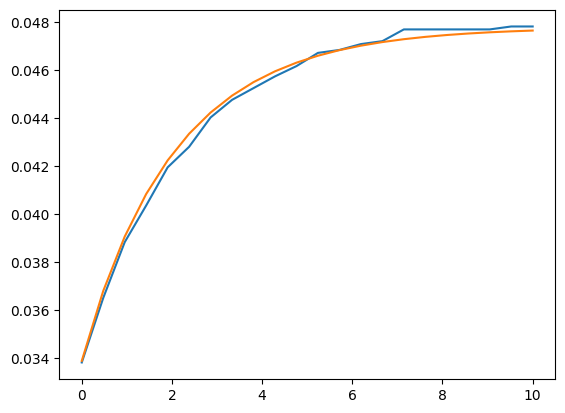

 Iter          Cost_f           Error
    0    3.084429e-01    1.770473e-02
   59    1.141888e+00    8.408494e-13
 Iter          Cost_f           Error
    0    4.963122e-01    4.889091e-03
   55    1.302638e+00    5.180376e-13
 Iter          Cost_f           Error
    0    5.992719e-01    4.174869e-03
   55    1.440638e+00    6.094970e-13
 Iter          Cost_f           Error
    0    6.877335e-01    3.583636e-03
   56    1.559413e+00    9.852975e-13
 Iter          Cost_f           Error
    0    7.638516e-01    3.069129e-03
   53    1.661939e+00    7.976778e-13
 Iter          Cost_f           Error
    0    8.296471e-01    2.623055e-03
   54    1.750665e+00    9.722320e-13
 Iter          Cost_f           Error
    0    8.864907e-01    2.211443e-03
   57    1.827557e+00    9.099090e-13
 Iter          Cost_f           Error
    0    9.357207e-01    1.912996e-03
   55    1.894507e+00    9.290724e-13
 Iter          Cost_f           Error
    0    9.785354e-01    1.597070e-03
   56    1.9

[np.float64(0.0324859619140625), np.float64(0.0341949462890625), np.float64(0.0360260009765625), np.float64(0.0372467041015625), np.float64(0.0387115478515625), np.float64(0.0395660400390625), np.float64(0.0403594970703125), np.float64(0.0413360595703125), np.float64(0.0420684814453125), np.float64(0.0427398681640625), np.float64(0.0434112548828125), np.float64(0.0437774658203125), np.float64(0.0441436767578125), np.float64(0.0447540283203125), np.float64(0.0451202392578125), np.float64(0.0452423095703125), np.float64(0.0454864501953125), np.float64(0.0457305908203125), np.float64(0.0460357666015625), np.float64(0.0464019775390625), np.float64(0.0467071533203125), np.float64(0.0467071533203125), np.float64(0.0469512939453125), np.float64(0.0469512939453125), np.float64(0.0471954345703125), np.float64(0.0471954345703125), np.float64(0.0475616455078125), np.float64(0.0476837158203125), np.float64(0.0476837158203125), np.float64(0.0476837158203125), np.float64(0.0476837158203125), np.floa

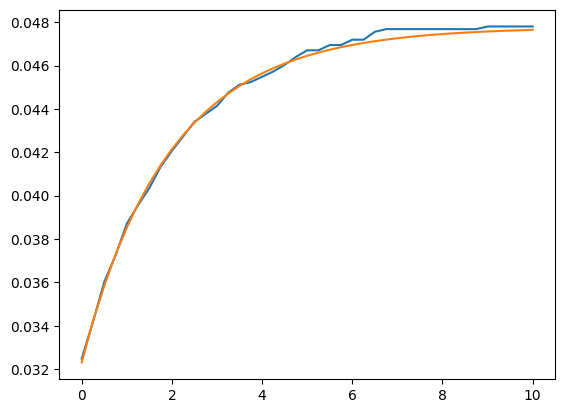

 Iter          Cost_f           Error
    0    3.072704e-01    1.818080e-02
   55    1.159520e+00    7.092287e-13
 Iter          Cost_f           Error
    0    4.568773e-01    3.086002e-03
   53    1.264662e+00    9.406797e-13
 Iter          Cost_f           Error
    0    5.291684e-01    2.841856e-03
   54    1.360923e+00    9.029876e-13
 Iter          Cost_f           Error
    0    5.952410e-01    2.576209e-03
   54    1.448940e+00    7.192357e-13
 Iter          Cost_f           Error
    0    6.556413e-01    2.374969e-03
   52    1.529678e+00    9.836845e-13
 Iter          Cost_f           Error
    0    7.109898e-01    2.173576e-03
   53    1.603682e+00    7.976667e-13
 Iter          Cost_f           Error
    0    7.617309e-01    1.973357e-03
   52    1.671571e+00    9.515929e-13
 Iter          Cost_f           Error
    0    8.082100e-01    1.796564e-03
   54    1.733955e+00    6.759923e-13
 Iter          Cost_f           Error
    0    8.508532e-01    1.642530e-03
   55    1.7

[np.float64(0.0316925048828125), np.float64(0.0327301025390625), np.float64(0.0338287353515625), np.float64(0.0347442626953125), np.float64(0.0357818603515625), np.float64(0.0365142822265625), np.float64(0.0372467041015625), np.float64(0.0379180908203125), np.float64(0.0387115478515625), np.float64(0.0391998291015625), np.float64(0.0396881103515625), np.float64(0.0402374267578125), np.float64(0.0410919189453125), np.float64(0.0413360595703125), np.float64(0.0417022705078125), np.float64(0.0420684814453125), np.float64(0.0424957275390625), np.float64(0.0427398681640625), np.float64(0.0434112548828125), np.float64(0.0437774658203125), np.float64(0.0437774658203125), np.float64(0.0440216064453125), np.float64(0.0443878173828125), np.float64(0.0447540283203125), np.float64(0.0448760986328125), np.float64(0.0451202392578125), np.float64(0.0452423095703125), np.float64(0.0452423095703125), np.float64(0.0454864501953125), np.float64(0.0456085205078125), np.float64(0.0457305908203125), np.floa

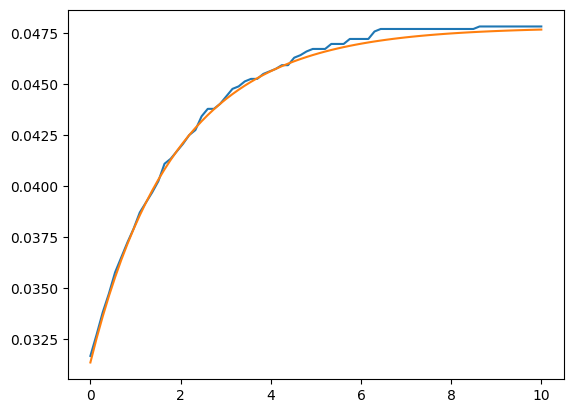

 Iter          Cost_f           Error
    0    3.065730e-01    1.846120e-02
   52    1.170845e+00    6.847379e-13
 Iter          Cost_f           Error
    0    4.275357e-01    1.846102e-03
   47    1.234646e+00    7.690656e-13
 Iter          Cost_f           Error
    0    4.732220e-01    1.754071e-03
   53    1.295262e+00    8.037956e-13
 Iter          Cost_f           Error
    0    5.165972e-01    1.680380e-03
   51    1.352971e+00    5.212047e-13
 Iter          Cost_f           Error
    0    5.578452e-01    1.577719e-03
   52    1.407873e+00    8.201853e-13
 Iter          Cost_f           Error
    0    5.971046e-01    1.513783e-03
   52    1.460093e+00    4.426190e-13
 Iter          Cost_f           Error
    0    6.344483e-01    1.434693e-03
   53    1.509732e+00    9.097320e-13
 Iter          Cost_f           Error
    0    6.699042e-01    1.357344e-03
   49    1.557061e+00    9.733936e-13
 Iter          Cost_f           Error
    0    7.036840e-01    1.289054e-03
   49    1.6

[np.float64(0.0309600830078125), np.float64(0.0318145751953125), np.float64(0.0323638916015625), np.float64(0.0329742431640625), np.float64(0.0338287353515625), np.float64(0.0341949462890625), np.float64(0.0343780517578125), np.float64(0.0352935791015625), np.float64(0.0357818603515625), np.float64(0.0361480712890625), np.float64(0.0365142822265625), np.float64(0.0370025634765625), np.float64(0.0374298095703125), np.float64(0.0377960205078125), np.float64(0.0382843017578125), np.float64(0.0387115478515625), np.float64(0.0390777587890625), np.float64(0.0393218994140625), np.float64(0.0395660400390625), np.float64(0.0399322509765625), np.float64(0.0401153564453125), np.float64(0.0406036376953125), np.float64(0.0410919189453125), np.float64(0.0413360595703125), np.float64(0.0413360595703125), np.float64(0.0417022705078125), np.float64(0.0417022705078125), np.float64(0.0420684814453125), np.float64(0.0421905517578125), np.float64(0.0424957275390625), np.float64(0.0427398681640625), np.floa

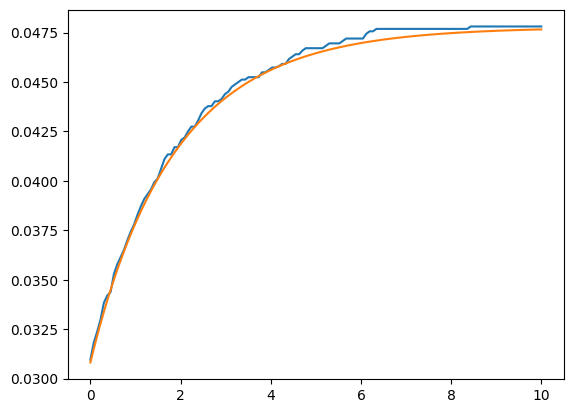

 Iter          Cost_f           Error
    0    3.061443e-01    1.861678e-02
   50    1.177544e+00    5.286307e-13
 Iter          Cost_f           Error
    0    4.087947e-01    1.064019e-03
   49    1.214772e+00    6.150896e-13
 Iter          Cost_f           Error
    0    4.360244e-01    1.038157e-03
   49    1.250986e+00    7.993602e-13
 Iter          Cost_f           Error
    0    4.625395e-01    1.007940e-03
   48    1.286188e+00    5.295922e-13
 Iter          Cost_f           Error
    0    4.883274e-01    9.710027e-04
   48    1.320376e+00    6.276651e-13
 Iter          Cost_f           Error
    0    5.133630e-01    9.380390e-04
   48    1.353649e+00    9.110413e-13
 Iter          Cost_f           Error
    0    5.377322e-01    9.279723e-04
   49    1.386014e+00    8.834545e-13
 Iter          Cost_f           Error
    0    5.614210e-01    8.968381e-04
   48    1.417493e+00    5.297438e-13
 Iter          Cost_f           Error
    0    5.844425e-01    8.714975e-04
   47    1.4

[np.float64(0.0308990478515625), np.float64(0.0310821533203125), np.float64(0.0316925048828125), np.float64(0.0318145751953125), np.float64(0.0319366455078125), np.float64(0.0326080322265625), np.float64(0.0329742431640625), np.float64(0.0333404541015625), np.float64(0.0338287353515625), np.float64(0.0339508056640625), np.float64(0.0341949462890625), np.float64(0.0341949462890625), np.float64(0.0349273681640625), np.float64(0.0352935791015625), np.float64(0.0354156494140625), np.float64(0.0356597900390625), np.float64(0.0360260009765625), np.float64(0.0362701416015625), np.float64(0.0363922119140625), np.float64(0.0367584228515625), np.float64(0.0368804931640625), np.float64(0.0371246337890625), np.float64(0.0373687744140625), np.float64(0.0375518798828125), np.float64(0.0377960205078125), np.float64(0.0380401611328125), np.float64(0.0382843017578125), np.float64(0.0387115478515625), np.float64(0.0387115478515625), np.float64(0.0390777587890625), np.float64(0.0390777587890625), np.floa

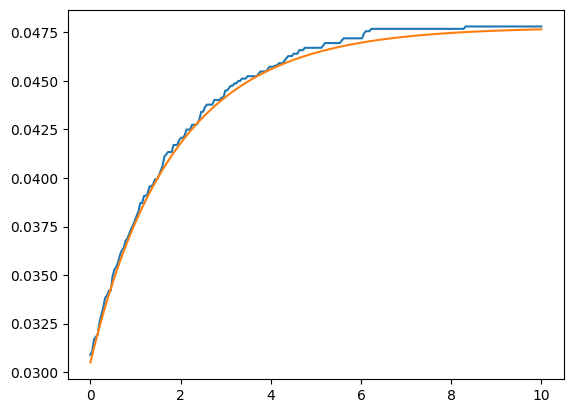

 Iter          Cost_f           Error
    0    3.059119e-01    1.870367e-02
   54    1.181382e+00    5.876839e-13
 Iter          Cost_f           Error
    0    3.975642e-01    6.033647e-04
   47    1.202666e+00    7.374800e-13
 Iter          Cost_f           Error
    0    4.133571e-01    5.934997e-04
   47    1.223606e+00    5.689860e-13
 Iter          Cost_f           Error
    0    4.288911e-01    5.777254e-04
   46    1.244215e+00    9.681962e-13
 Iter          Cost_f           Error
    0    4.441663e-01    5.758453e-04
   49    1.264515e+00    8.080283e-13
 Iter          Cost_f           Error
    0    4.592102e-01    5.650218e-04
   48    1.284501e+00    7.214156e-13
 Iter          Cost_f           Error
    0    4.740149e-01    5.558834e-04
   45    1.304169e+00    8.171633e-13
 Iter          Cost_f           Error
    0    4.885934e-01    5.469236e-04
   46    1.323518e+00    6.541777e-13
 Iter          Cost_f           Error
    0    5.029381e-01    5.395683e-04
   46    1.3

[np.float64(0.0306549072265625), np.float64(0.0308990478515625), np.float64(0.0308990478515625), np.float64(0.0313262939453125), np.float64(0.0314483642578125), np.float64(0.0316925048828125), np.float64(0.0318145751953125), np.float64(0.0319366455078125), np.float64(0.0319366455078125), np.float64(0.0324859619140625), np.float64(0.0327301025390625), np.float64(0.0328521728515625), np.float64(0.0329742431640625), np.float64(0.0333404541015625), np.float64(0.0333404541015625), np.float64(0.0337066650390625), np.float64(0.0338287353515625), np.float64(0.0339508056640625), np.float64(0.0340728759765625), np.float64(0.0341949462890625), np.float64(0.0341949462890625), np.float64(0.0343170166015625), np.float64(0.0346221923828125), np.float64(0.0350494384765625), np.float64(0.0352935791015625), np.float64(0.0352935791015625), np.float64(0.0354156494140625), np.float64(0.0356597900390625), np.float64(0.0357818603515625), np.float64(0.0360260009765625), np.float64(0.0360260009765625), np.floa

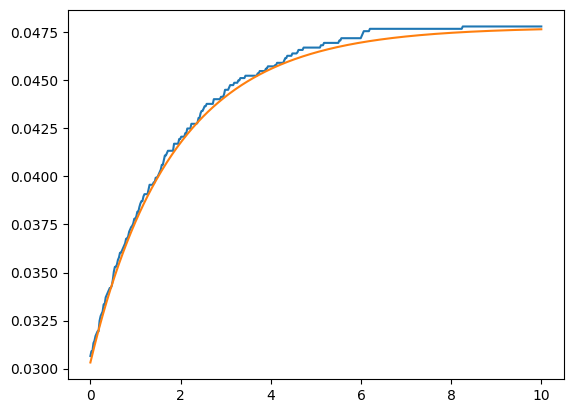

 Iter          Cost_f           Error
    0    3.057827e-01    1.875198e-02
   56    1.183556e+00    9.393733e-13
 Iter          Cost_f           Error
    0    3.910855e-01    3.385541e-04
   44    1.195570e+00    7.791724e-13
 Iter          Cost_f           Error
    0    4.000528e-01    3.361296e-04
   33    1.207482e+00    9.608728e-13
 Iter          Cost_f           Error
    0    4.089422e-01    3.345929e-04
   44    1.219291e+00    5.565227e-13
 Iter          Cost_f           Error
    0    4.177660e-01    3.296060e-04
   44    1.230990e+00    9.508496e-13
 Iter          Cost_f           Error
    0    4.265037e-01    3.246957e-04
   44    1.242580e+00    8.156635e-13
 Iter          Cost_f           Error
    0    4.351574e-01    3.257791e-04
   43    1.254075e+00    6.117949e-13
 Iter          Cost_f           Error
    0    4.437437e-01    3.226240e-04
   44    1.265475e+00    7.093672e-13
 Iter          Cost_f           Error
    0    4.522610e-01    3.201231e-04
   43    1.2

[np.float64(0.0305328369140625), np.float64(0.0306549072265625), np.float64(0.0308990478515625), np.float64(0.0308990478515625), np.float64(0.0308990478515625), np.float64(0.0309600830078125), np.float64(0.0313262939453125), np.float64(0.0313262939453125), np.float64(0.0314483642578125), np.float64(0.0316925048828125), np.float64(0.0316925048828125), np.float64(0.0318145751953125), np.float64(0.0318145751953125), np.float64(0.0319366455078125), np.float64(0.0319366455078125), np.float64(0.0319366455078125), np.float64(0.0323638916015625), np.float64(0.0324859619140625), np.float64(0.0326080322265625), np.float64(0.0327301025390625), np.float64(0.0328521728515625), np.float64(0.0329742431640625), np.float64(0.0329742431640625), np.float64(0.0332183837890625), np.float64(0.0333404541015625), np.float64(0.0333404541015625), np.float64(0.0333404541015625), np.float64(0.0337066650390625), np.float64(0.0338287353515625), np.float64(0.0338287353515625), np.float64(0.0338287353515625), np.floa

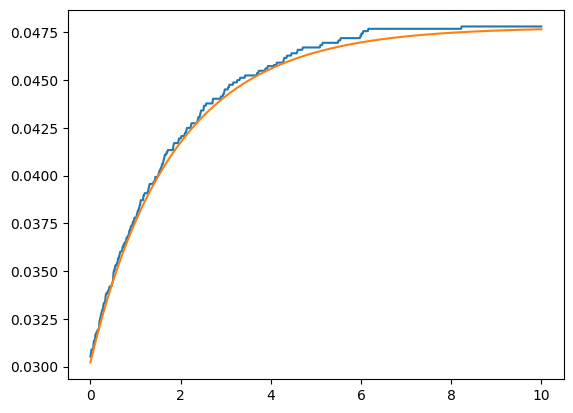

In [43]:

for time_steps in time_steps_list:
    dt = (t1 - t0) / time_steps
    Ac_tamaas = []
    Ac_Johnson_ref = []
    # Solver
    solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)
    solver.reset()

    for i in range(time_steps):
        solver.solve(p_target)
        contact_area_result = np.mean(model.traction > 0) * L**2
        normalized_result = contact_area_result / L**2      ######normalized contact area
        Ac_tamaas.append(normalized_result)

    for t in np.arange(t0, t1, dt):        
        Ac_Johnson_ref.append((3 / 8 * Radius * W * (1 / g_1 + 1 / g_2 * (1 - np.exp(-t / tau_c[0]))))**(2/3) * np.pi)


    Ac_tamaas = Ac_tamaas[:-1]
    Ac_Johnson_ref = Ac_Johnson_ref[1:]

    L2_norm = np.sqrt(np.sum((np.array(Ac_tamaas) - np.array(Ac_Johnson_ref))**2))
    error = L2_norm / np.linalg.norm(Ac_Johnson_ref) 
    error_list.append(error)

    plt.plot(np.linspace(t0, t1, time_steps-1), Ac_tamaas, label='Tamaas')
    plt.plot(np.linspace(t0, t1, time_steps-1), Ac_Johnson_ref, label='Johnson')
    plt.show()


In [44]:
print(error_list)

[np.float64(0.03572705708774282), np.float64(0.02079628823788361), np.float64(0.012655815389082593), np.float64(0.005624701209044515), np.float64(0.0045795036426250334), np.float64(0.00527251163682051), np.float64(0.006065159427404709), np.float64(0.006566028182521853), np.float64(0.006739756358013185), np.float64(0.00694014903211779)]


[np.float64(2.5), np.float64(1.4285714285714286), np.float64(0.8333333333333334), np.float64(0.43478260869565216), np.float64(0.23809523809523808), np.float64(0.13333333333333333), np.float64(0.07352941176470588), np.float64(0.04065040650406504), np.float64(0.02252252252252252), np.float64(0.0125)]


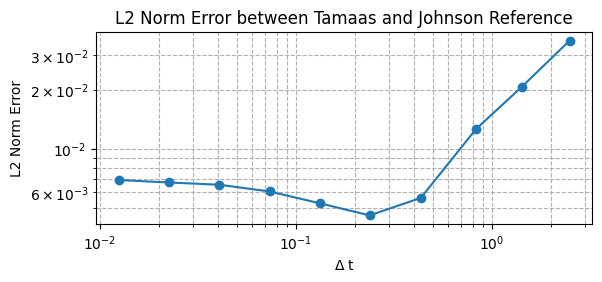

In [45]:
dt_list = [(t1 - t0) / time_steps for time_steps in time_steps_list]
print(dt_list)
# Plot log-log graph of L2 norms
plt.figure()
plt.loglog(dt_list, error_list, marker='o')
plt.xlabel('$\Delta$ t')
plt.ylabel('L2 Norm Error')
plt.title('L2 Norm Error between Tamaas and Johnson Reference')
plt.grid(True, which="both", ls="--")
plt.gca().set_aspect('equal')
plt.show()